# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv")
df = data.copy()

In [3]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
columns = ["Make",
"Model",
"Year",
"Engine HP",
"Engine Cylinders",
"Transmission Type",
"Vehicle Style",
"highway MPG",
"city mpg",
"MSRP"]

In [5]:
df = df[columns]

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df = df.fillna(0)
df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920


In [8]:
df.rename(columns={"msrp": "above_average"}, inplace = True)
df["above_average"].where(df["above_average"] < df.above_average.mean(), 1, inplace=True)
df["above_average"].where(df["above_average"] <= 1, 0, inplace=True)

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
X_train = df_train.drop('above_average', axis=1)
y_train = df_train.above_average.values

X_val = df_val.drop('above_average', axis=1)
y_val = df_val.above_average.values

# Q1 - ROC AUC feature importance


In [10]:
numerical_variable = [col for col in df_train.columns if df_train[col].dtype in ['int64', 'float64'] and col != 'year']

In [11]:
 

def roc_auc_score_numerical_variable(df_train, numerical_variable):
    scores = []
    for col in numerical_variable:
        auc_score = roc_auc_score(df_train.above_average, df_train[col])
        scores.append((col, auc_score))
    return scores

In [12]:
scores = roc_auc_score_numerical_variable(df_train, numerical_variable)
for col, score in sorted(scores, key=lambda x: -x[1]):
    print(col, score)

above_average 1.0
engine_hp 0.9171031265539011
engine_cylinders 0.766116490165669
highway_mpg 0.3669412128227987
city_mpg 0.3265755356754767


# Q2 - Training the model


In [13]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(X_train.to_dict(orient='records'))
X_val = dv.transform(X_val.to_dict(orient='records'))


lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

round(roc_auc_score(y_val, lr.fit(X_train, y_train).predict_proba(X_val)[:, 1]), 3)

0.979

# Q3 - Precision and Recall

In [14]:
thresholds = np.linspace(0, 1, 101)

In [15]:
precision_list = []
recall_list = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (lr.predict_proba(X_val)[:, 1] >= t)
    predict_negative = (lr.predict_proba(X_val)[:, 1] < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    precision_list.append(precision)
    recall_list.append(recall)

C:\Users\Emirh\AppData\Local\Temp\ipykernel_10852\3048055623.py:16: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


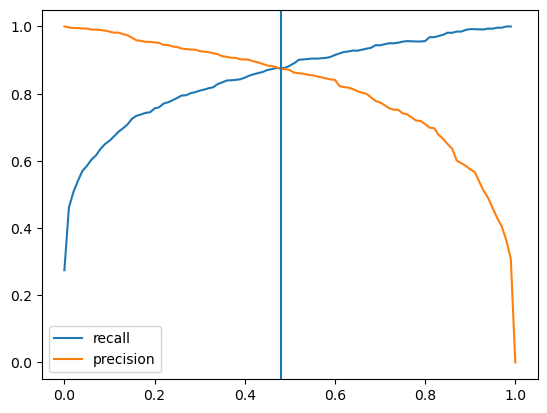

In [16]:
plt.plot(thresholds, precision_list, label = "recall")
plt.plot(thresholds, recall_list, label = "precision")
plt.axvline(x = 0.48)
plt.legend() 
plt.show()

# Q4 - F1 score


In [17]:
thresholds = np.linspace(0, 1, 101)

In [18]:
f1_score = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (lr.predict_proba(X_val)[:, 1] >= t)
    predict_negative = (lr.predict_proba(X_val)[:, 1] < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * precision * recall / (precision + recall)

    f1_score.append(f1)

C:\Users\Emirh\AppData\Local\Temp\ipykernel_10852\2769231596.py:15: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [19]:
# maximum f1 score threshold value

thresholds[f1_score.index(max(f1_score))]

0.52

# Q5 - 5-Fold CV


In [20]:
def train(X_train, y_train, C=1.0):
    dicts = X_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [21]:
def predict(X, dv, model):
    dicts = X.to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [22]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [25]:
score = []

for train_idx, val_idx in tqdm(KFold(n_splits=5, shuffle=True, random_state=1).split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train.drop('above_average', axis=1), y_train, C=1.0)

    y_pred = predict(df_val.drop('above_average', axis=1), dv, model)

    auc = roc_auc_score(y_val, y_pred)

    score.append(auc)

0it [00:00, ?it/s]

In [26]:
round(np.std(score), 3)

0.003

# Q6 -  Hyperparemeter Tuning


In [27]:
c_list = [0.01, 0.1, 0.5, 10]

In [28]:
c_score = {c: [] for c in c_list}

for c in tqdm(c_list):

    for train_idx, val_idx in tqdm(KFold(n_splits=5, shuffle=True, random_state=1).split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train.drop('above_average', axis=1), y_train, C=c)

        y_pred = predict(df_val.drop('above_average', axis=1), dv, model)

        auc = roc_auc_score(y_val, y_pred)

        c_score[c].append(auc)

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [29]:
for c, score in c_score.items():
    print(c, round(np.mean(score), 3), round(np.std(score), 3))

0.01 0.952 0.002
0.1 0.972 0.002
0.5 0.979 0.004
10 0.984 0.003
